In [1]:
%load_ext autoreload
%autoreload 2

In [31]:
%matplotlib inline 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

from utils import *
from utils_plotting import *
from utils_evaluation import *

In [3]:
sns.set(style='ticks')

# Prepare data

In [4]:
kids_x_sdss = process_kids('/media/snakoneczny/data/KiDS/KiDS.DR3.x.SDSS.DR14.cols.csv', sdss_cleaning=True, cut='r')

Data shape: (91317, 49)
Droping NANs: 89513 left
Removing limiting magnitudes: 74196 left
Removing errors bigger than 1: 74191 left
Removing KiDS flags: 55787 left
Cleaning SDSS: 52010 left
Removing R > 22: 51752 left


In [5]:
catalog_star = pd.read_csv('catalogs/KiDS_DR3_x_SDSS_DR14_star_sdss-clean_rf-clf_f-all_cut-r__2018-08-06_12:35:10.csv')
catalog_non_star = pd.read_csv('catalogs/KiDS_DR3_x_SDSS_DR14_non-star_sdss-clean_rf-clf_f-all_cut-r__2018-08-06_12:39:06.csv')

print(catalog_star.shape)
print(catalog_non_star.shape)

(1364535, 18)
(2028045, 18)


In [6]:
kids_x_gaia = process_kids('/media/snakoneczny/data/KiDS/KiDS.DR3.x.GAIA.DR2.cols.csv', sdss_cleaning=False, cut='r')

Data shape: (1965257, 54)
Droping NANs: 1937863 left
Removing limiting magnitudes: 1619408 left
Removing errors bigger than 1: 1619387 left
Removing KiDS flags: 1080301 left
Removing R > 22: 1080253 left


In [7]:
for catalog in [catalog_star, catalog_non_star]:
    catalog['train'] = catalog['ID'].isin(kids_x_sdss['ID'])

catalog = pd.concat([catalog_star, catalog_non_star])
print(catalog.shape)

(3392580, 19)


In [8]:
catalog_x_gaia = pd.merge(catalog, kids_x_gaia, on='ID', suffixes=('', '_right'))

In [9]:
qso_kids_sdss = kids_x_sdss.loc[kids_x_sdss['CLASS'] == 'QSO']
qso_catalog = catalog.loc[catalog['CLASS'] == 'QSO']

In [10]:
qso_catalog_star = catalog_star.loc[catalog_star['CLASS'] == 'QSO']
qso_catalog_non_star = catalog_non_star.loc[catalog_non_star['CLASS'] == 'QSO']

In [11]:
catalog_sampled = catalog.sample(n=500000, random_state=1567)
qso_catalog_sampled = qso_catalog.sample(n=100000, random_state=1567)

In [12]:
catalog_star_sampled = catalog_star.sample(20000, random_state=78356)
catalog_non_star_sampled = catalog_non_star.sample(20000, random_state=78356)

In [13]:
catalog_north = catalog.loc[catalog['DECJ2000'] > -15]
catalog_south = catalog.loc[catalog['DECJ2000'] < -15]

In [14]:
kids_x_sdss_star = kids_x_sdss.loc[kids_x_sdss['CLASS_STAR'] >= 0.5]
kids_x_sdss_non_star = kids_x_sdss.loc[kids_x_sdss['CLASS_STAR'] <= 0.5]

In [15]:
catalog_star_non_train = catalog_star.loc[catalog_star['train'] == False]
qso_catalog_star_non_train = qso_catalog_star.loc[qso_catalog_star['train'] == False]

# Describe data

In [16]:
print(qso_catalog_star.shape[0])
print(qso_catalog_non_star.shape[0])

177103
12469


In [17]:
describe_column(kids_x_sdss['CLASS'])

(array(['GALAXY', 'QSO', 'STAR'], dtype=object),
 array([32547,  7061, 12144]),
 array([62.89032308, 13.64391714, 23.46575978]))

In [18]:
describe_column(kids_x_sdss_star['CLASS'])

(array(['GALAXY', 'QSO', 'STAR'], dtype=object),
 array([  163,  6381, 11912]),
 array([ 0.88318162, 34.57412224, 64.54269614]))

In [19]:
describe_column(kids_x_sdss_non_star['CLASS'])

(array(['GALAXY', 'QSO', 'STAR'], dtype=object),
 array([32384,   680,   232]),
 array([97.26093224,  2.04228736,  0.69678039]))

In [20]:
describe_column(catalog['CLASS'])

(array(['GALAXY', 'QSO', 'STAR'], dtype=object),
 array([2013280,  189572, 1189728]),
 array([59.34362638,  5.5878417 , 35.06853191]))

In [21]:
describe_column(catalog_x_gaia['CLASS'])

(array(['GALAXY', 'QSO', 'STAR'], dtype=object),
 array([  40762,   38184, 1001307]),
 array([ 3.77337531,  3.53472751, 92.69189718]))

In [22]:
describe_column(catalog_north['CLASS'])

(array(['GALAXY', 'QSO', 'STAR'], dtype=object),
 array([1294620,  122842,  846607]),
 array([57.18111948,  5.42571803, 37.39316249]))

In [23]:
describe_column(catalog_south['CLASS'])

(array(['GALAXY', 'QSO', 'STAR'], dtype=object),
 array([718660,  66730, 343121]),
 array([63.68214399,  5.91310142, 30.40475458]))

In [24]:
describe_column(catalog_star['CLASS'])

(array(['GALAXY', 'QSO', 'STAR'], dtype=object),
 array([   4830,  177103, 1182602]),
 array([ 0.35396674, 12.97900017, 86.66703309]))

In [25]:
describe_column(catalog_non_star['CLASS'])

(array(['GALAXY', 'QSO', 'STAR'], dtype=object),
 array([2008450,   12469,    7126]),
 array([99.03379856,  0.61482857,  0.35137287]))

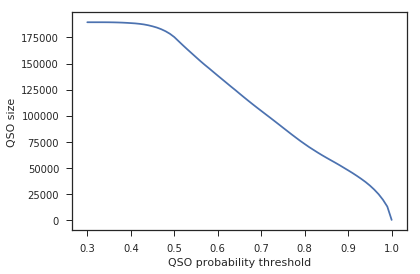

In [26]:
plot_proba_against_size(qso_catalog, column='QSO', x_lim=(0.3, 1))

# External catalogs

catalog size: 3392580
(array(['GALAXY', 'QSO', 'STAR'], dtype=object), array([2013280,  189572, 1189728]), array([59.34362638,  5.5878417 , 35.06853191]))
--------------------
KiDS.DR3.x.QSO.RICHARDS.2009
ext. catalog x base set size: 19930
ext. catalog x base catalog size: 16851, train elements: 3508
catalogs cross:
(array(['GALAXY', 'QSO', 'STAR'], dtype=object), array([  848, 14543,  1460]), array([ 5.03234229, 86.30348347,  8.66417423]))
catalogs cross, no train:
(array(['GALAXY', 'QSO', 'STAR'], dtype=object), array([  820, 11155,  1368]), array([ 6.14554448, 83.60188863, 10.25256689]))


/home/snakoneczny/tools/python3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


--------------------
KiDS.DR3.x.QSO.RICHARDS.2015
ext. catalog x base set size: 22368
ext. catalog x base catalog size: 17883, train elements: 3953
catalogs cross:
(array(['GALAXY', 'QSO', 'STAR'], dtype=object), array([  504, 16224,  1155]), array([ 2.81831907, 90.72303305,  6.45864788]))
catalogs cross, no train:
(array(['GALAXY', 'QSO', 'STAR'], dtype=object), array([  484, 12309,  1137]), array([ 3.47451543, 88.3632448 ,  8.16223977]))
--------------------
KiDS.DR3.x.QSO.GALEX
ext. catalog x base set size: 70749
ext. catalog x base catalog size: 42713, train elements: 6691
catalogs cross:
(array(['GALAXY', 'QSO', 'STAR'], dtype=object), array([ 4831, 31554,  6328]), array([11.31037389, 73.87446445, 14.81516166]))
catalogs cross, no train:
(array(['GALAXY', 'QSO', 'STAR'], dtype=object), array([ 4684, 25493,  5845]), array([13.00316473, 70.77064016, 16.2261951 ]))
--------------------
KiDS.DR3.x.2QZ6QZ.cols
ext. catalog x base set size: 6131
ext. catalog x base catalog size: 5376, t

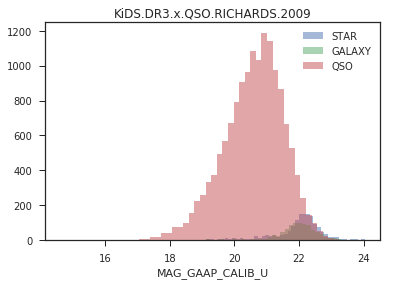

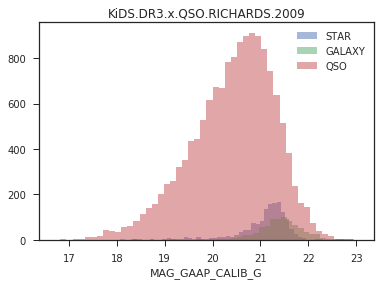

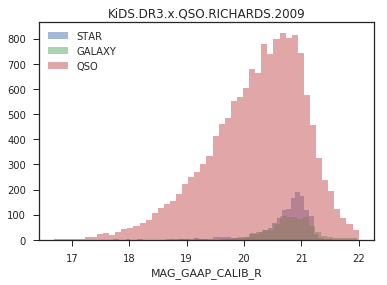

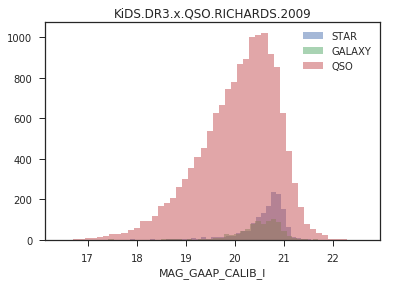

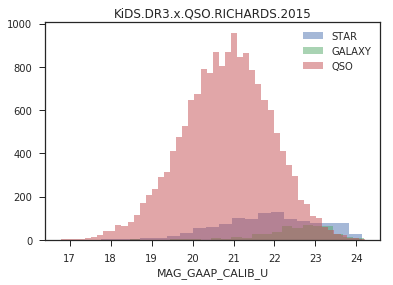

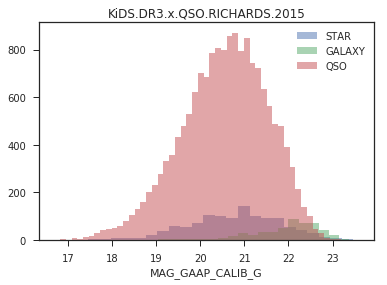

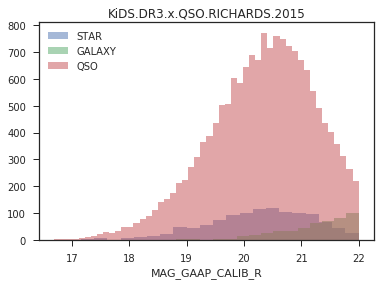

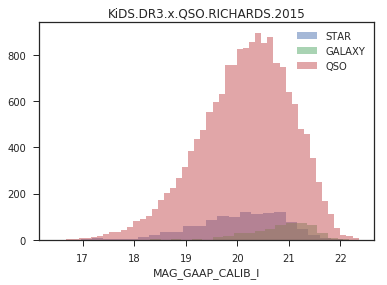

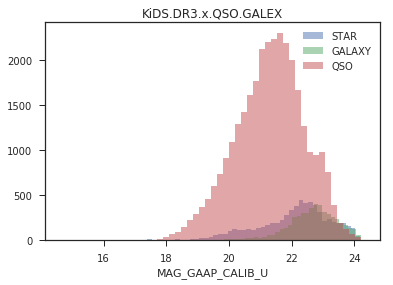

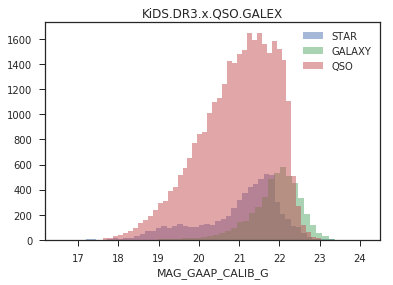

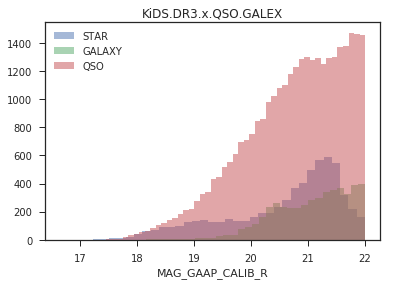

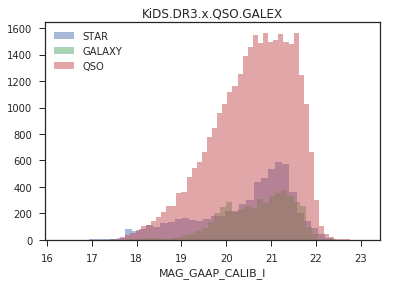

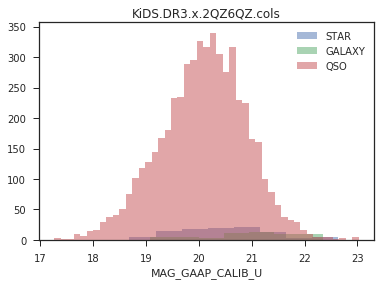

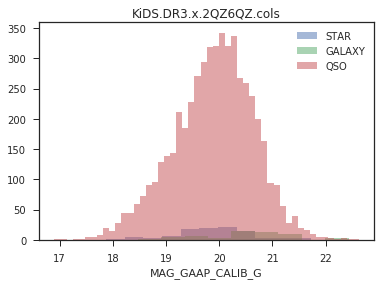

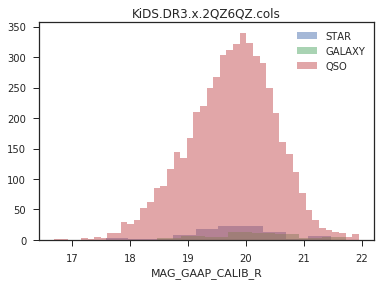

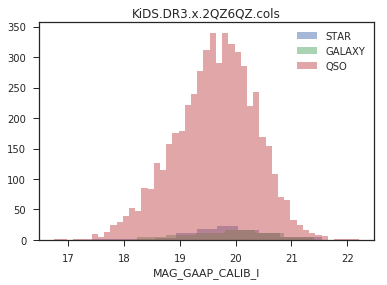

In [29]:
test_external_qso(catalog, save=False)

In [45]:
ext_catalog = pd.read_csv('/media/snakoneczny/data/KiDS/KiDS.DR3.x.2QZ6QZ.cols.csv')
ext_catalog = process_2df(ext_catalog)
ext_catalog = ext_catalog.loc[ext_catalog['id1'].isin(['GALAXY', 'QSO', 'STAR'])]
catalogs_cross = pd.merge(catalog, ext_catalog, on='ID', suffixes=('', '_right'))

Multiclass classification results:
Accuracy = 0.9432
F1 per class = [0.1495 0.9622 0.917 ]
Logloss = 0.4688


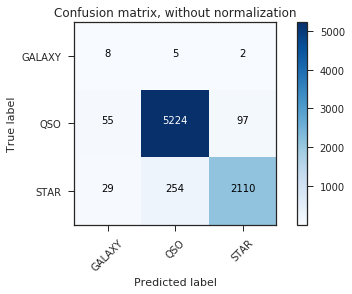

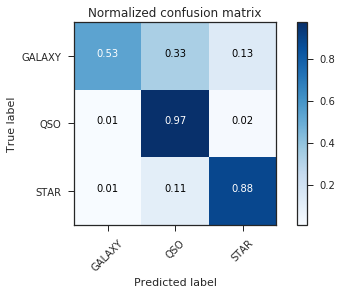

Binary classification results:
Predicted positives: 5483/7784 (70.44%)
logloss = 0.2953
ROC AUC = 0.9637


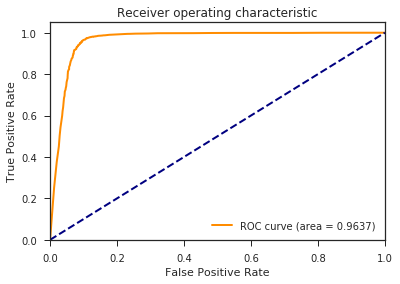

accuracy = 0.9472
f1 = 0.9622
precision = 0.9528
recall = 0.9717


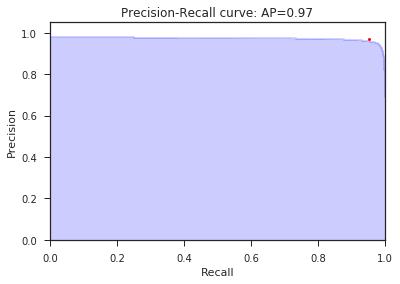

In [46]:
classification_report(catalogs_cross, col_true='id1', data_path=None)

catalog size: 1364535
(array(['GALAXY', 'QSO', 'STAR'], dtype=object), array([   4830,  177103, 1182602]), array([ 0.354, 12.979, 86.667]))
--------------------
KiDS.DR3.x.QSO.RICHARDS.2009
ext. catalog x base set size: 19930
ext. catalog x base catalog size: 15609, train elements: 3444
catalogs cross:
(array(['GALAXY', 'QSO', 'STAR'], dtype=object), array([   51, 14104,  1454]), array([ 0.3267, 90.3581,  9.3151]))
catalogs cross, no train:
(array(['GALAXY', 'QSO', 'STAR'], dtype=object), array([   35, 10768,  1362]), array([ 0.2877, 88.5162, 11.1961]))


/home/snakoneczny/tools/python3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


--------------------
KiDS.DR3.x.QSO.RICHARDS.2015
ext. catalog x base set size: 22368
ext. catalog x base catalog size: 17152, train elements: 3892
catalogs cross:
(array(['GALAXY', 'QSO', 'STAR'], dtype=object), array([  104, 15900,  1148]), array([ 0.6063, 92.7006,  6.6931]))
catalogs cross, no train:
(array(['GALAXY', 'QSO', 'STAR'], dtype=object), array([   91, 12039,  1130]), array([ 0.6863, 90.7919,  8.5219]))
--------------------
KiDS.DR3.x.QSO.GALEX
ext. catalog x base set size: 70749
ext. catalog x base catalog size: 37226, train elements: 6510
catalogs cross:
(array(['GALAXY', 'QSO', 'STAR'], dtype=object), array([  343, 30616,  6267]), array([ 0.9214, 82.2436, 16.835 ]))
catalogs cross, no train:
(array(['GALAXY', 'QSO', 'STAR'], dtype=object), array([  280, 24644,  5792]), array([ 0.9116, 80.2318, 18.8566]))
--------------------
KiDS.DR3.x.2QZ6QZ.cols
ext. catalog x base set size: 6131
ext. catalog x base catalog size: 5153, train elements: 1153
catalogs cross:
(array(['GAL

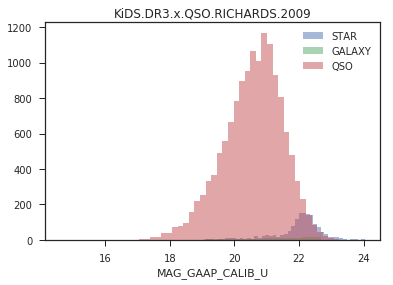

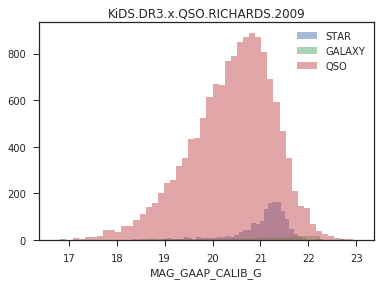

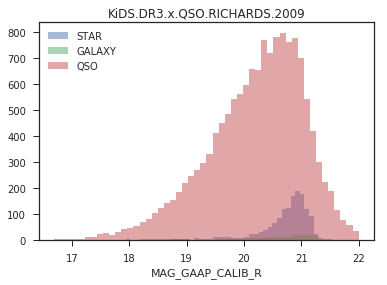

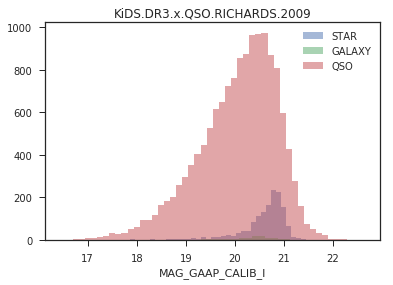

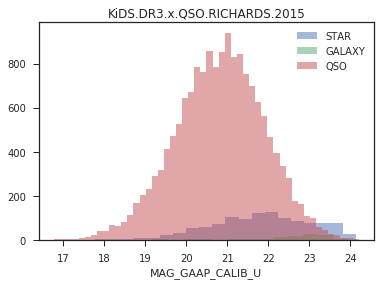

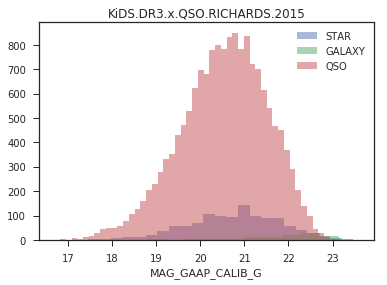

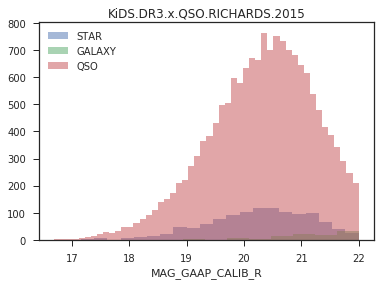

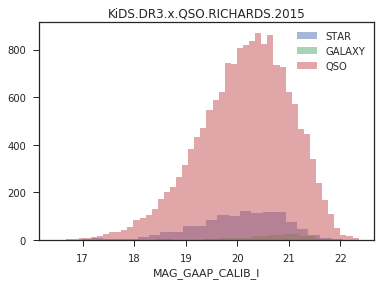

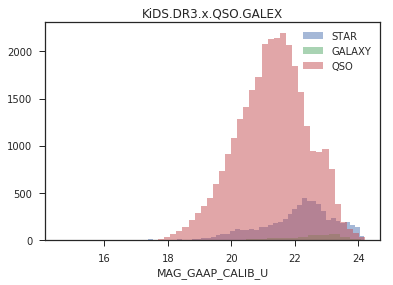

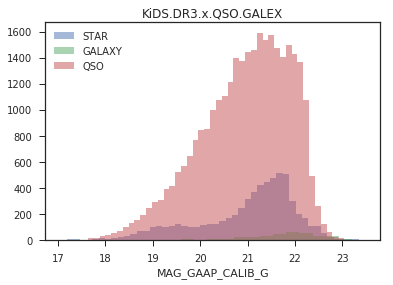

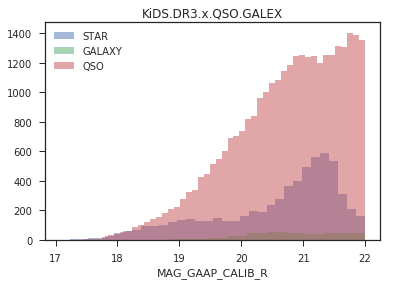

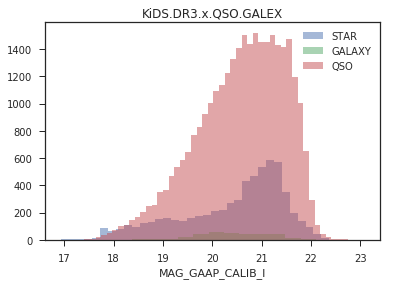

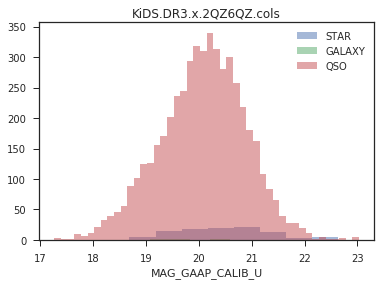

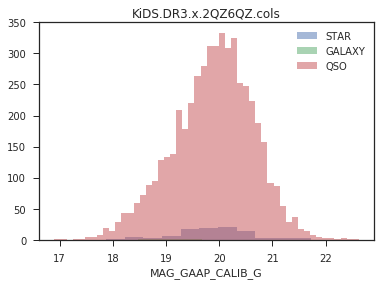

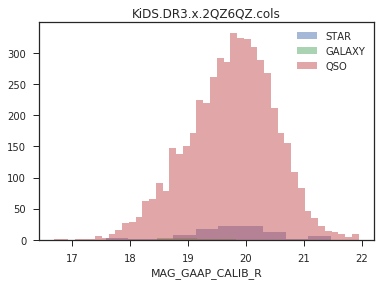

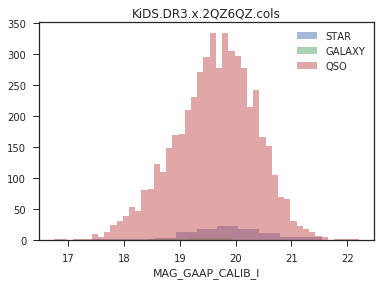

In [47]:
test_external_qso(catalog_star, save=False)

catalog size: 2028045
(array(['GALAXY', 'QSO', 'STAR'], dtype=object), array([2008450,   12469,    7126]), array([99.0338,  0.6148,  0.3514]))
--------------------
KiDS.DR3.x.QSO.RICHARDS.2009
ext. catalog x base set size: 19930
ext. catalog x base catalog size: 1242, train elements: 64
catalogs cross:
(array(['GALAXY', 'QSO', 'STAR'], dtype=object), array([797, 439,   6]), array([64.1707, 35.3462,  0.4831]))
catalogs cross, no train:
(array(['GALAXY', 'QSO', 'STAR'], dtype=object), array([785, 387,   6]), array([66.6384, 32.8523,  0.5093]))


/home/snakoneczny/tools/python3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


--------------------
KiDS.DR3.x.QSO.RICHARDS.2015
ext. catalog x base set size: 22368
ext. catalog x base catalog size: 731, train elements: 61
catalogs cross:
(array(['GALAXY', 'QSO', 'STAR'], dtype=object), array([400, 324,   7]), array([54.7196, 44.3228,  0.9576]))
catalogs cross, no train:
(array(['GALAXY', 'QSO', 'STAR'], dtype=object), array([393, 270,   7]), array([58.6567, 40.2985,  1.0448]))
--------------------
KiDS.DR3.x.QSO.GALEX
ext. catalog x base set size: 70749
ext. catalog x base catalog size: 5487, train elements: 181
catalogs cross:
(array(['GALAXY', 'QSO', 'STAR'], dtype=object), array([4488,  938,   61]), array([81.7933, 17.095 ,  1.1117]))
catalogs cross, no train:
(array(['GALAXY', 'QSO', 'STAR'], dtype=object), array([4404,  849,   53]), array([83.0004, 16.0008,  0.9989]))
--------------------
KiDS.DR3.x.2QZ6QZ.cols
ext. catalog x base set size: 6131
ext. catalog x base catalog size: 223, train elements: 33
catalogs cross:
(array(['GALAXY', 'QSO'], dtype=object)

/home/snakoneczny/tools/python3/lib/python3.5/site-packages/seaborn/distributions.py:195: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/home/snakoneczny/tools/python3/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


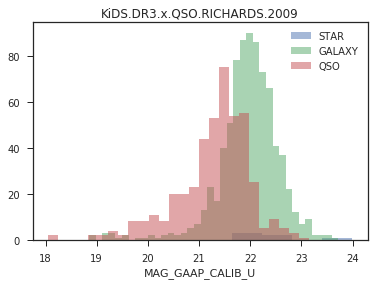

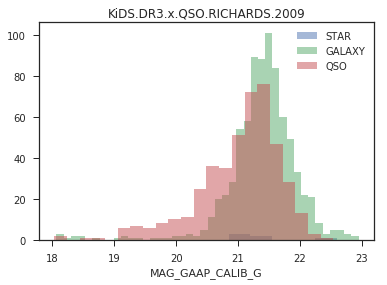

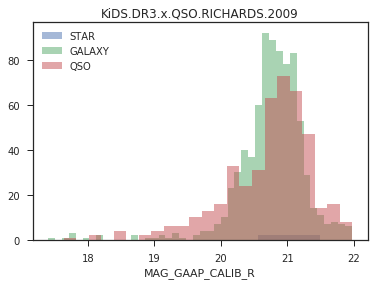

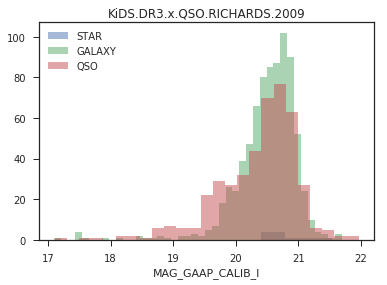

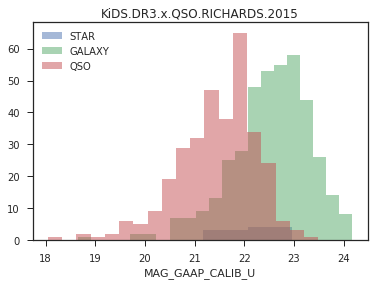

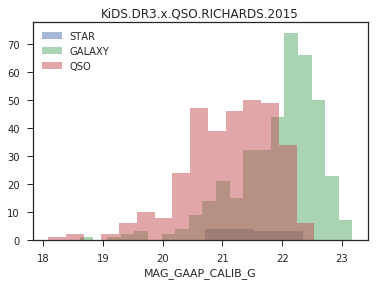

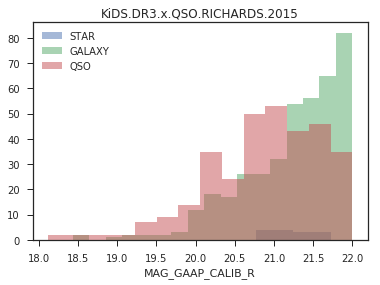

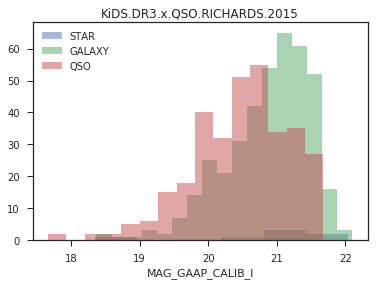

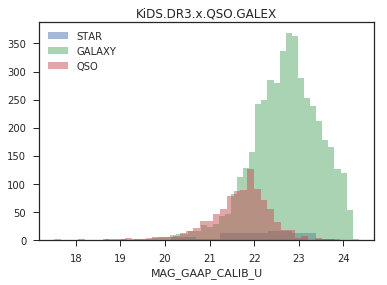

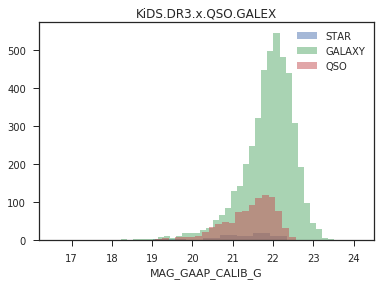

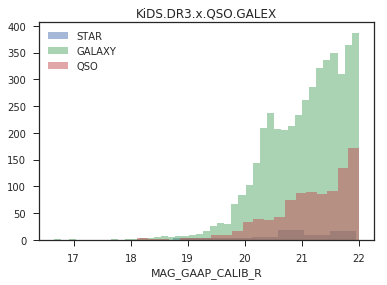

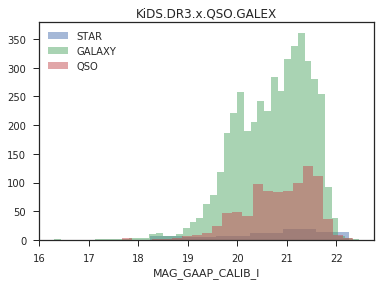

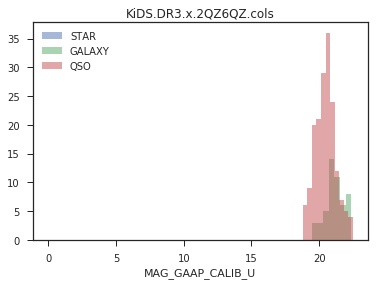

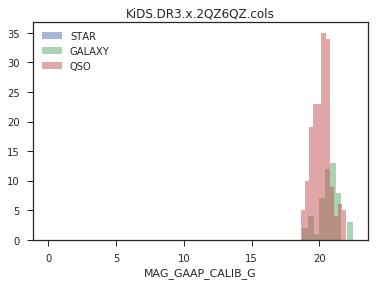

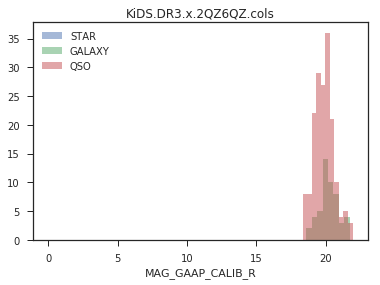

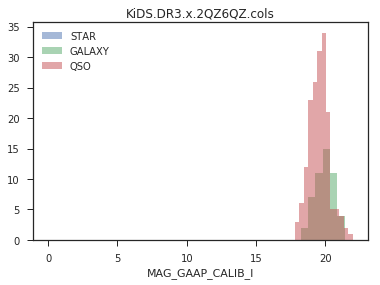

In [48]:
test_external_qso(catalog_non_star, save=False)

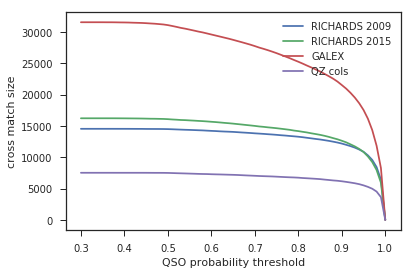

In [49]:
plot_proba_against_qxternal_qso(qso_catalog)

# GAIA motion test

Data shape: (1080253, 85)
5 position shape: (919796, 85)
Removing paralax_error shape: (805416, 85)
Removing pmra_error shape: (615601, 85)
Removing pmdec_error shape: (596231, 85)
Removing parallax_norm shape: (467032, 85)
Removing pmra_norm and pmdec_norm shape: (52190, 85)
(array(['GALAXY', 'QSO', 'STAR'], dtype=object), array([  219,  6438, 45533]), array([ 0.41962062, 12.33569649, 87.24468289]))


/home/snakoneczny/tools/python3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Mean:


,parallax_norm,pmra_norm,pmdec_norm
QSO,-0.0592677,-0.0274581,-0.0270715
GALAXY,-0.0603052,-0.0682943,-0.413702
STAR,0.641408,-0.836828,-1.02583


Sigma:


,parallax_norm,pmra_norm,pmdec_norm
QSO,1.06902,1.11526,1.12751
GALAXY,1.24203,1.80219,1.58178
STAR,1.38878,2.19113,2.03924


Median:


,parallax_norm,pmra_norm,pmdec_norm
QSO,-0.0552367,-0.0118317,-0.023305
GALAXY,-0.0674836,-0.00494892,-0.288918
STAR,0.546392,-1.0501,-1.13591


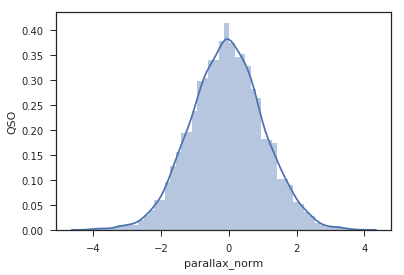

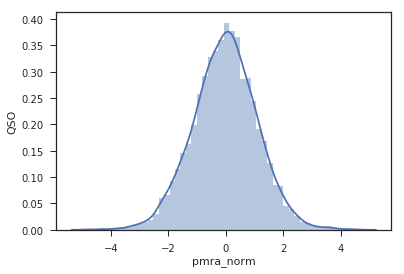

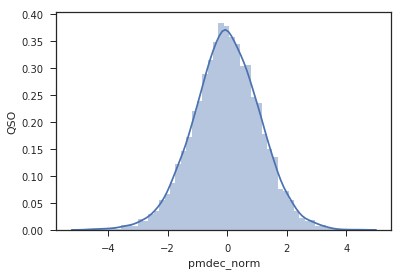

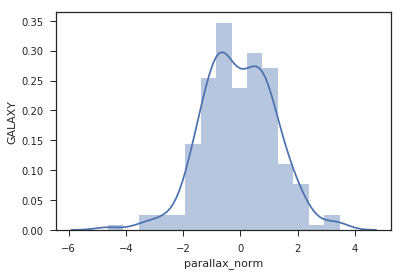

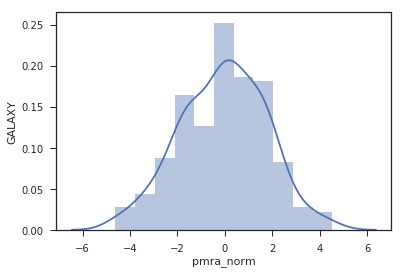

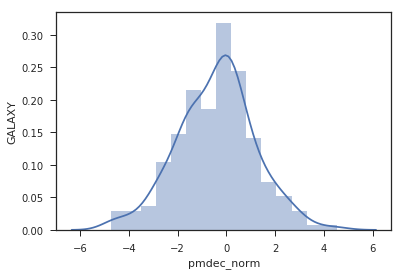

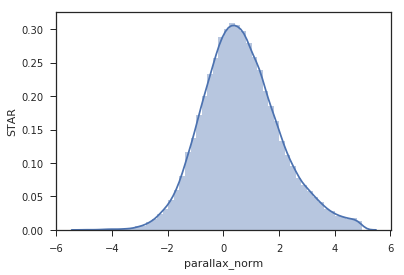

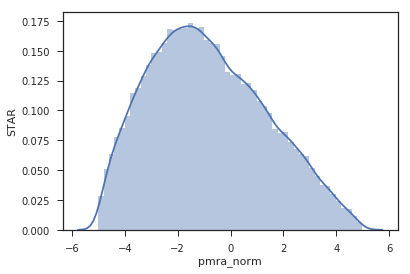

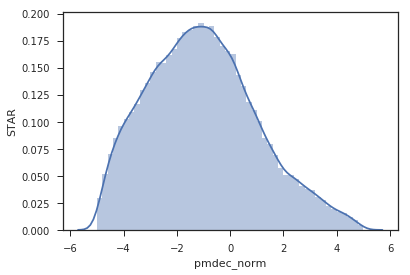

In [35]:
catalog_x_gaia_clean = process_gaia(catalog_x_gaia, error_lim=1, parallax_lim=(-5, 5), pm_lim=25)
print(describe_column(catalog_x_gaia_clean['CLASS']))
gaia_motion_analysis(catalog_x_gaia_clean)

Data shape: (1080253, 85)
5 position shape: (919796, 85)
Removing parallax_norm shape: (904759, 85)
Removing pmra_norm and pmdec_norm shape: (382572, 85)
(array(['GALAXY', 'QSO', 'STAR'], dtype=object), array([  3732,  23455, 355385]), array([ 0.97550265,  6.1308721 , 92.89362525]))


/home/snakoneczny/tools/python3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Mean:


,parallax_norm,pmra_norm,pmdec_norm
QSO,-0.00127989,-0.126249,-0.263802
GALAXY,0.00283911,-0.244217,-0.867021
STAR,0.587063,-1.37934,-2.4294


Sigma:


,parallax_norm,pmra_norm,pmdec_norm
QSO,1.12263,1.40708,1.5521
GALAXY,1.29522,2.31227,2.31197
STAR,1.51048,3.51921,3.29141


Median:


,parallax_norm,pmra_norm,pmdec_norm
QSO,-0.0110583,-0.0674552,-0.111194
GALAXY,-0.0111452,-0.149491,-0.443227
STAR,0.46539,-1.32842,-2.28872


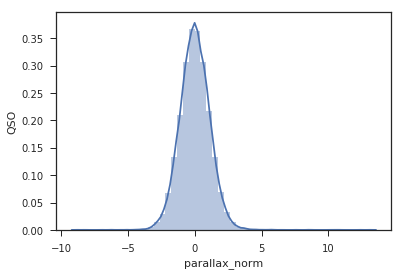

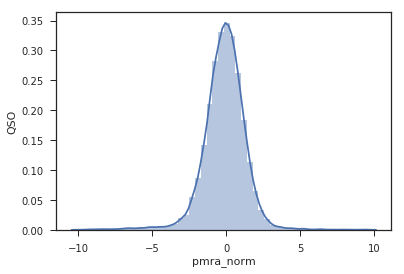

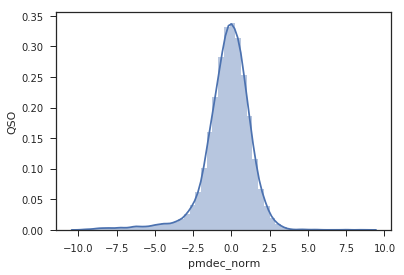

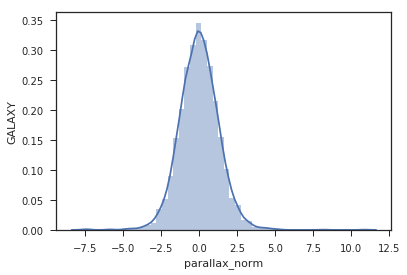

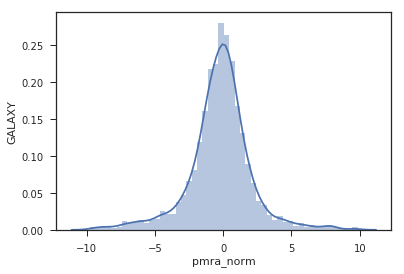

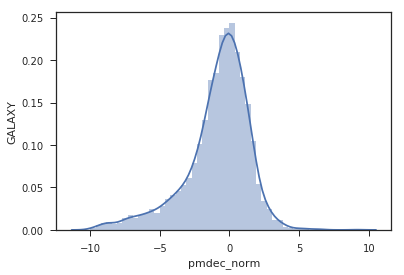

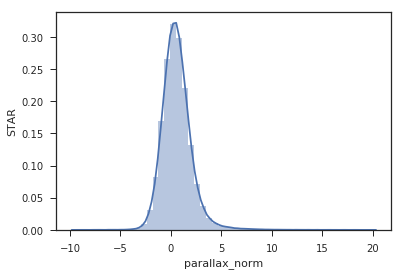

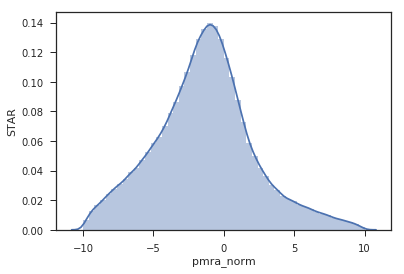

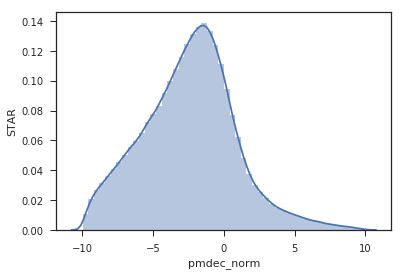

In [36]:
catalog_x_gaia_clean = process_gaia(catalog_x_gaia, error_lim=None, parallax_lim=(-10, 20), pm_lim=100)
print(describe_column(catalog_x_gaia_clean['CLASS']))
gaia_motion_analysis(catalog_x_gaia_clean)

/home/snakoneczny/tools/python3/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:187: RuntimeWarning: Mean of empty slice.
  loc = data.mean()
/home/snakoneczny/tools/python3/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/snakoneczny/tools/python3/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:192: RuntimeWarning: Mean of empty slice.
  scale = np.sqrt(((data - loc)**2).mean())
/home/snakoneczny/tools/python3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


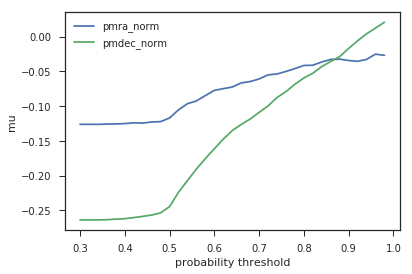

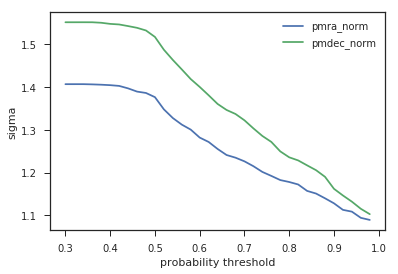

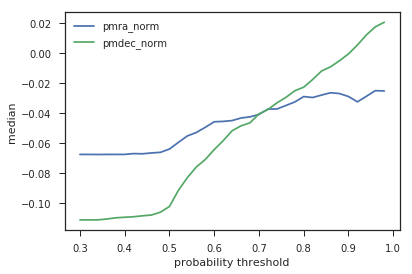

In [37]:
proba_motion_analysis(catalog_x_gaia_clean, motions=['pmra_norm', 'pmdec_norm'])

# t-SNE visualization

## Star

In [38]:
catalog_to_plot = kids_x_sdss.loc[kids_x_sdss['CLASS_STAR'] >= 0.5].sample(10000, random_state=8945)
catalog_to_plot['CLASS'] += '_SDSS'
catalog_to_plot = catalog_to_plot.append(catalog_star.loc[~catalog_star['ID'].isin(kids_x_sdss['ID'])].sample(10000, random_state=1467))

In [39]:
X = catalog_to_plot[FEATURES['magnitudes-colors-cstar']]
X_scaled = MinMaxScaler().fit_transform(X)

In [40]:
X_embedded = TSNE(n_components=2, perplexity=30.0, early_exaggeration=12.0, learning_rate=200.0, n_iter=1000,
                  n_iter_without_progress=300, min_grad_norm=1e-07, metric='euclidean', init='random', verbose=0,
                  random_state=8934, method='barnes_hut', angle=0.5).fit_transform(X_scaled)

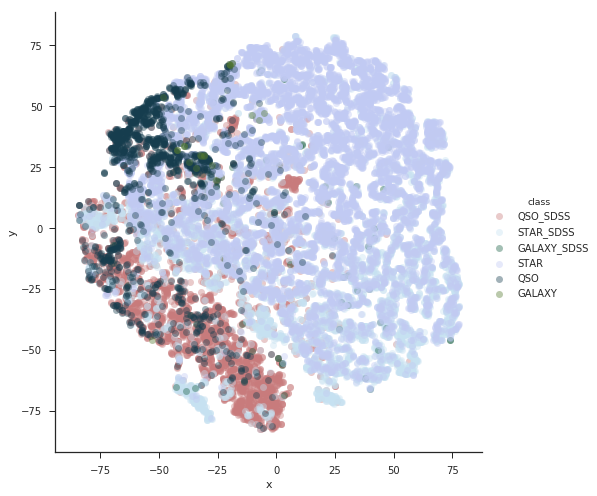

In [41]:
plot_embedding(X_embedded, catalog_to_plot['CLASS'], label='class', alpha=0.4)

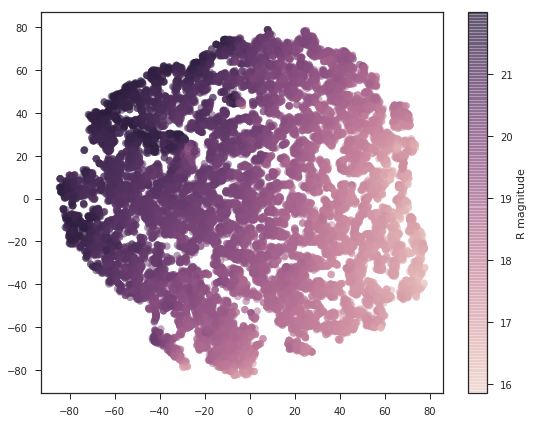

In [42]:
plot_embedding(X_embedded, catalog_to_plot[MAG_GAAP_CALIB_R], label='R magnitude', is_continuous=True)

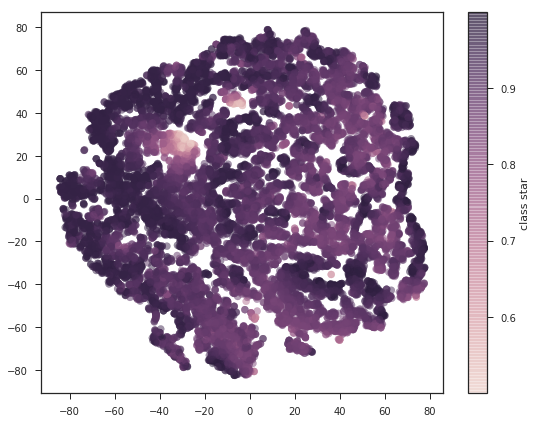

In [43]:
plot_embedding(X_embedded, catalog_to_plot['CLASS_STAR'], label='class star', is_continuous=True)

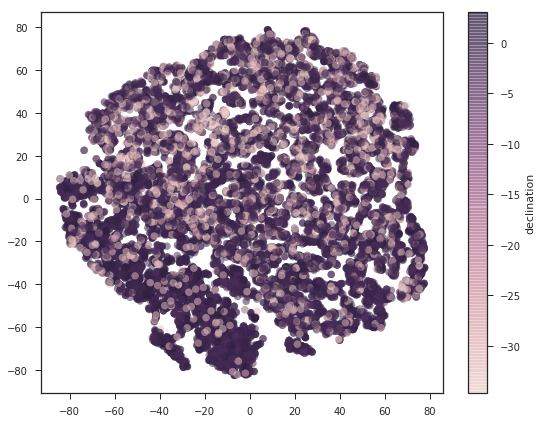

In [44]:
plot_embedding(X_embedded, catalog_to_plot['DECJ2000'], label='declination', is_continuous=True)

## Non-star

In [ ]:
catalog_to_plot = kids_x_sdss.loc[kids_x_sdss['CLASS_STAR']<= 0.5].sample(10000, random_state=8945)
catalog_to_plot['CLASS'] += '_SDSS'
catalog_to_plot = catalog_to_plot.append(catalog_non_star.loc[~catalog_non_star['ID'].isin(kids_x_sdss['ID'])].sample(10000, random_state=1467))

In [ ]:
X = catalog_to_plot[FEATURES['magnitudes-colors-cstar']]
X_scaled = MinMaxScaler().fit_transform(X)

In [ ]:
X_embedded = TSNE(n_components=2, perplexity=30.0, early_exaggeration=12.0, learning_rate=200.0, n_iter=1000,
                  n_iter_without_progress=300, min_grad_norm=1e-07, metric='euclidean', init='random', verbose=0,
                  random_state=8934, method='barnes_hut', angle=0.5).fit_transform(X_scaled)

In [ ]:
plot_embedding(X_embedded, catalog_to_plot['CLASS'], label='class', alpha=0.4)

In [ ]:
plot_embedding(X_embedded, catalog_to_plot[MAG_GAAP_CALIB_R], label='R magnitude', is_continuous=True)

In [ ]:
plot_embedding(X_embedded, catalog_to_plot['CLASS_STAR'], label='R magnitude', is_continuous=True)

# Standalone bands

In [ ]:
plot_class_histograms(kids_x_sdss, BAND_CALIB_COLUMNS)

In [ ]:
plot_class_histograms(catalog, BAND_CALIB_COLUMNS)

In [ ]:
plot_class_histograms(catalog_north, BAND_CALIB_COLUMNS)

In [ ]:
plot_class_histograms(catalog_south, BAND_CALIB_COLUMNS)

# Paired bands

In [ ]:
sns.pairplot(kids_x_sdss[np.concatenate([BAND_CALIB_COLUMNS, ['CLASS']])], hue='CLASS', plot_kws={'alpha': 0.25})

In [ ]:
sns.pairplot(catalog_sampled[np.concatenate([BAND_CALIB_COLUMNS, ['CLASS']])], hue='CLASS', plot_kws={'alpha': 0.25})

# Standalone colors

In [ ]:
plot_class_histograms(kids_x_sdss, COLOR_COLUMNS)

In [ ]:
plot_class_histograms(catalog, COLOR_COLUMNS)

# Paired colors

In [ ]:
sns.pairplot(kids_x_sdss[np.concatenate([COLOR_COLUMNS, ['CLASS']])], hue='CLASS', plot_kws={'alpha': 0.25})

In [ ]:
sns.pairplot(catalog_sampled[np.concatenate([COLOR_COLUMNS, ['CLASS']])], hue='CLASS', plot_kws={'alpha': 0.25})

In [ ]:
for b_1, b_2 in COLOR_PAIRS:
    sns.set(style='ticks')
    sns.lmplot(x=b_1, y=b_2, hue='CLASS', data=kids_x_sdss, fit_reg=False, scatter_kws={'alpha': 0.25})

In [ ]:
for b_1, b_2 in COLOR_PAIRS:
    sns.set(style='ticks')
    sns.lmplot(x=b_1, y=b_2, hue='CLASS', data=catalog_sampled, fit_reg=False, scatter_kws={'alpha': 0.25})

## CLASS_STAR

In [ ]:
for b_1, b_2 in COLOR_PAIRS:
    sns.set(style='ticks')
    sns.lmplot(x=b_1, y=b_2, hue='CLASS', data=kids_x_sdss_non_star, fit_reg=False, scatter_kws={'alpha': 0.25})

In [ ]:
for b_1, b_2 in COLOR_PAIRS:
    sns.set(style='ticks')
    sns.lmplot(x=b_1, y=b_2, hue='CLASS', data=catalog_non_star, fit_reg=False, scatter_kws={'alpha': 0.25})

# QSO color pairs

In [ ]:
for b_1, b_2 in COLOR_PAIRS:
    sns.set(style='ticks')
    sns.jointplot(qso_kids_sdss[b_1], qso_kids_sdss[b_2], kind='kde', stat_func=None)

In [ ]:
for b_1, b_2 in COLOR_PAIRS:
    sns.set(style='ticks')
    sns.jointplot(qso_catalog_sampled[b_1], qso_catalog_sampled[b_2], kind='kde', stat_func=None)

# Number counts analysis

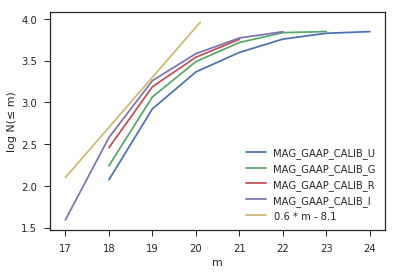

In [49]:
number_count_analysis(qso_kids_sdss, c=8.1, linear_range=(17, 20))

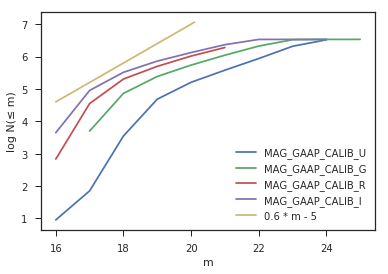

In [50]:
number_count_analysis(catalog, c=5, linear_range=(16, 20))

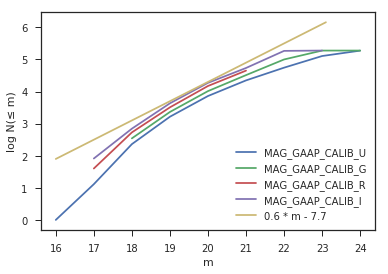

In [51]:
number_count_analysis(qso_catalog, c=7.7, linear_range=(16, 23))

# Maps

## Create maps

In [ ]:
nside = 128

In [ ]:
# map_stars, lon, lat = get_weighted_map(nside=128)

In [ ]:
map_stars = np.loadtxt('/home/snakoneczny/workspace/kids_quasars/maps/GAIA_DR2_nside-{}_hpxmap.txt'.format(nside))

In [ ]:
map_kids_sdss, lon, lat = get_map(kids_x_sdss['GAL_LONG'], kids_x_sdss['GAL_LAT'], nside=nside)

In [ ]:
map_qso_kids_sdss, _, _ = get_map(qso_kids_sdss['GAL_LONG'], qso_kids_sdss['GAL_LAT'], nside=nside)

In [ ]:
map_catalog, _, _ = get_map(catalog['GAL_LONG'], catalog['GAL_LAT'], nside=nside)

In [ ]:
map_catalog_star, _, _ = get_map(catalog_star['GAL_LONG'], catalog_star['GAL_LAT'], nside=nside)

In [ ]:
map_qso_catalog, _, _ = get_map(qso_catalog['GAL_LONG'], qso_catalog['GAL_LAT'], nside=nside)

In [ ]:
tmp = qso_catalog.loc[qso_catalog['QSO'] > 0.7]
map_qso_catalog_high, _, _ = get_map(tmp['GAL_LONG'], tmp['GAL_LAT'], nside=nside)

In [ ]:
map_qso_normalized = normalize_map(map_qso_catalog, map_catalog)

In [ ]:
qso_catalog_parts = get_kids_parts(qso_catalog)
catalog_parts = get_kids_parts(catalog)

In [ ]:
map_qso_catalog_parts = [get_map(part['GAL_LONG'], part['GAL_LAT'], nside=nside)[0] for part in qso_catalog_parts]

In [ ]:
map_catalog_parts = [get_map(part['GAL_LONG'], part['GAL_LAT'], nside=nside)[0] for part in catalog_parts]

## Correlations

In [ ]:
# nside = 128
maps_x = [('catalog', map_catalog), ('QSO cat.', map_qso_catalog), ('QSO cat. norm.', map_qso_normalized),
          ('QSO cat. high', map_qso_catalog_high)]
maps_x.extend([('catalog part {}'.format(i + 1), m) for i, m in enumerate(map_catalog_parts)])
maps_x.extend([('qso part {}'.format(i + 1), m) for i, m in enumerate(map_qso_catalog_parts)])
maps_y = [('catalog', map_catalog), ('stars', map_stars), ('train', map_kids_sdss), ('train QSO', map_qso_kids_sdss)]

show_correlations(maps_x, maps_y)

In [ ]:
# nside = 1028
maps_x = [('catalog', map_catalog), ('QSO cat.', map_qso_catalog), ('QSO cat. norm.', map_qso_normalized),
          ('QSO cat. high', map_qso_catalog_high)]
maps_x.extend([('catalog part {}'.format(i + 1), m) for i, m in enumerate(map_catalog_parts)])
maps_x.extend([('qso part {}'.format(i + 1), m) for i, m in enumerate(map_qso_catalog_parts)])
maps_y = [('catalog', map_catalog), ('stars', map_stars), ('train', map_kids_sdss), ('train QSO', map_qso_kids_sdss)]

show_correlations(maps_x, maps_y)

In [ ]:
maps_x = [('catalog star', map_catalog), ('QSO', map_qso_catalog), ('QSO norm.', map_qso_normalized)]
maps_x.extend([('catalog part {}'.format(i + 1), m) for i, m in enumerate(map_catalog_parts)])
maps_x.extend([('qso part {}'.format(i + 1), m) for i, m in enumerate(map_qso_catalog_parts)])
maps_y = [('catalog star', map_catalog), ('stars', map_stars), ('train', map_kids_sdss), ('train QSO', map_qso_kids_sdss)]

show_correlations(maps_x, maps_y)

In [ ]:
%matplotlib inline
plot_map_stats(map_qso_catalog_parts[3], lat, map_stars, 'catalog QSO')

## Map visualization

In [ ]:
%matplotlib notebook
plot_map(map_stars, unit='average value per pixel', is_cmap=False)

In [ ]:
%matplotlib inline
plot_non_zero_map_stats(map_stars, lat)

In [ ]:
%matplotlib notebook
plot_map(map_kids_sdss)

In [ ]:
%matplotlib inline
plot_non_zero_map_stats(map_kids_sdss, lat, map_stars, 'KiDS x SDSS')

In [ ]:
%matplotlib notebook
plot_map(map_qso_kids_sdss)

In [ ]:
%matplotlib inline
plot_non_zero_map_stats(map_qso_kids_sdss, lat, map_stars, 'KiDS x SDSS QSO')

In [ ]:
%matplotlib notebook
plot_map(map_catalog)

In [ ]:
%matplotlib inline
plot_non_zero_map_stats(map_catalog, lat, map_stars, 'catalog')

In [ ]:
%matplotlib notebook
plot_map(map_qso_catalog)

In [ ]:
%matplotlib inline
plot_non_zero_map_stats(map_qso_catalog, lat, map_stars, 'catalog QSO')

In [ ]:
%matplotlib notebook
plot_map(map_qso_catalog_high)

In [ ]:
%matplotlib inline
plot_non_zero_map_stats(map_qso_catalog_high, lat, map_stars, 'catalog QSO')

In [ ]:
%matplotlib notebook
plot_map(map_qso_normalized, unit='normalized counts per pixel')

In [ ]:
%matplotlib inline
plot_non_zero_map_stats(map_qso_normalized, lat, map_stars, 'catalog QSO normalized')

# Predictions

In [ ]:
for t in [0, 1]:
    sns.distplot(catalog_star.loc[(catalog_star['train'] == t) & (catalog_star['CLASS'] == 'QSO')]['QSO'], label=str(t), kde=False, rug=False, hist_kws={'alpha': 0.5})
plt.legend()

In [ ]:
for t in [0, 1]:
    sns.distplot(catalog_non_star.loc[(catalog_non_star['train'] == t) & (catalog_non_star['CLASS'] == 'QSO')]['QSO'], label=str(t), kde=False, rug=False, hist_kws={'alpha': 0.5})
plt.legend()